In [28]:
#importing the libraries and reading the data
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity



In [6]:
#reading the data
df = pd.read_csv('spotify_Song_Dataset/dataset.csv')

#removing the row with null values
df = df.dropna()

#dropping duration and explicit columns 
df = df.drop(['duration_ms','explicit','mode','liveness','loudness','time_signature','key'],axis=1)

#labels first column as song_id
df.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)

Index(['song_id', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'tempo', 'track_genre'],
      dtype='object')


,song_id,track_id,artists,album_name,track_name,popularity,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,0.676,0.4610,0.1430,0.0322,0.000001,0.715,87.917,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,0.420,0.1660,0.0763,0.9240,0.000006,0.267,77.489,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,0.438,0.3590,0.0557,0.2100,0.000000,0.120,76.332,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,0.266,0.0596,0.0363,0.9050,0.000071,0.143,181.740,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,0.618,0.4430,0.0526,0.4690,0.000000,0.167,119.949,acoustic


In [43]:


# Define the continuous audio features and popularity for scaling
features_to_scale = ['popularity', 'danceability', 'energy', 'acousticness', 'valence', 'tempo', 'speechiness', 'instrumentalness']

# Recompute z-scores and handle extreme outliers (only for the continuous features)
z_scores = stats.zscore(df[features_to_scale]) #compute z scores for each continous feature
outliers = (z_scores > 5) | (z_scores < -5)
df = df[(~outliers).all(axis=1)] #removes all songs with at least one outlier

# Initialize the MinMaxScaler to scale features between 0 and 1
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
scaled_features = scaler.fit_transform(df[features_to_scale])

# Convert the scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)

# Add the original identification and categorical columns back to the DataFrame
df_scaled['song_id'] = df['song_id']
df_scaled['track_id'] = df['track_id']
df_scaled['artist_name'] = df['artists'].fillna('')  # Fill NaN with an empty string
df_scaled['track_name'] = df['track_name']
df_scaled['album_name'] = df['album_name'].fillna('')  # Fill NaN with an empty string
df_scaled['track_genre'] = df['track_genre'].fillna('')  # Fill NaN with an empty string

# Handling missing data by dropping any rows with NaN values
df_scaled = df_scaled.dropna()

# Reordering the DataFrame columns to have song information first
df_scaled = df_scaled[['song_id', 'track_id', 'artist_name', 'track_name', 'album_name', 'track_genre', 
                       'popularity', 'energy', 'acousticness', 'valence', 'tempo', 'speechiness', 'instrumentalness']]


,song_id,track_id,artist_name,track_name,album_name,track_genre,popularity,energy,acousticness,valence,tempo,speechiness,instrumentalness
0,0.0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,acoustic,0.73,0.4610,0.032329,0.718593,0.361245,0.331019,0.000001
1,1.0,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost - Acoustic,Ghost (Acoustic),acoustic,0.55,0.1660,0.927711,0.268342,0.318397,0.176620,0.000006
2,2.0,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,acoustic,0.57,0.3590,0.210843,0.120603,0.313643,0.128935,0.000000
3,3.0,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Can't Help Falling In Love,Crazy Rich Asians (Original Motion Picture Sou...,acoustic,0.71,0.0596,0.908635,0.143719,0.746758,0.084028,0.000071
4,4.0,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,acoustic,0.82,0.4430,0.470884,0.167839,0.492863,0.121759,0.000000


In [22]:


# Initialize the OneHotEncoder (no need for sparse argument here)
onehot_encoder = OneHotEncoder()

# Fit and transform the 'track_genre' column to one-hot encoded format
genre_encoded = onehot_encoder.fit_transform(df_scaled[['track_genre']])

# Convert the encoded array to a DataFrame with appropriate column names
genre_encoded_df = pd.DataFrame(genre_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(['track_genre']))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_scaled = pd.concat([df_scaled, genre_encoded_df], axis=1)

#showing maximum table columns
pd.set_option('display.max_columns', None)

## Polynomial features 

In [24]:
#duplicate values
duplicate = df_scaled.duplicated()
#dropping duplicate values
df_scaled = df_scaled.drop_duplicates()


0


In [27]:
#dropping the NaN values
df_scaled = df_scaled.dropna()


#saving the final dataset
final_df = df_scaled
final_df.to_csv('spotify_Song_Dataset/final_dataset.csv',index=False)

In [29]:
#dropping the nan values
final_df = final_df.dropna()

#checking for nan values
print(final_df.isnull().sum())

song_id                    0
track_id                   0
artist_name                0
track_name                 0
album_name                 0
                          ..
track_genre_trance         0
track_genre_trip-hop       0
track_genre_turkish        0
track_genre_world-music    0
track_genre_nan            0
Length: 472, dtype: int64


C:\Users\hrish\AppData\Local\Temp\ipykernel_36460\855184209.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_songs_df['cluster'] = clusters


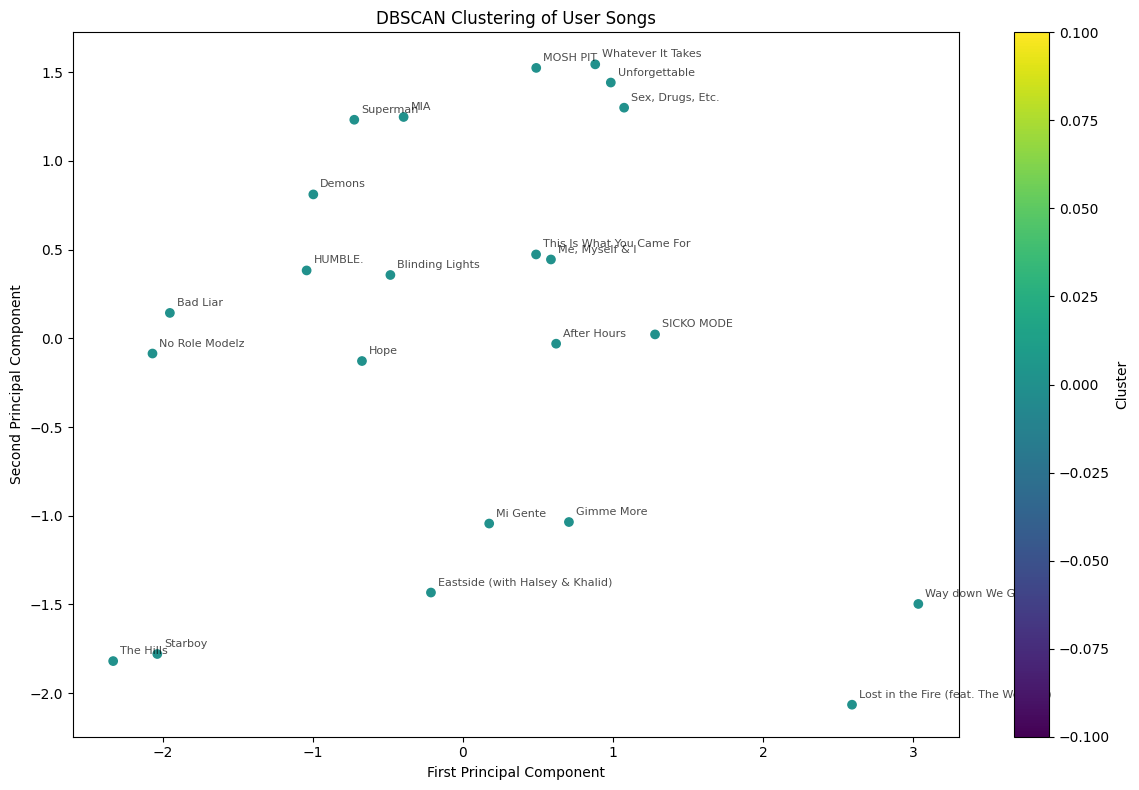


Clustering Results:
Number of clusters: 1

Cluster 0 (Size: 23):
  - Lost in the Fire (feat. The Weeknd) by Gesaffelstein;The Weeknd
  - Eastside (with Halsey & Khalid) by benny blanco;Halsey;Khalid
  - Gimme More by Britney Spears
  - Hope by XXXTENTACION
  - Unforgettable by French Montana;Swae Lee
  - No Role Modelz by J. Cole
  - HUMBLE. by Kendrick Lamar
  - Superman by Eminem;Dina Rae
  - SICKO MODE by Travis Scott
  - This Is What You Came For by Calvin Harris;Rihanna
  - Me, Myself & I by G-Eazy;Bebe Rexha
  - Way down We Go by KALEO
  - MIA by Bad Bunny;Drake
  - Mi Gente by J Balvin;Willy William
  - Blinding Lights by The Weeknd
  - Starboy by The Weeknd;Daft Punk
  - The Hills by The Weeknd
  - After Hours by The Weeknd
  - Sex, Drugs, Etc. by Beach Weather
  - Whatever It Takes by Imagine Dragons
  - Demons by Imagine Dragons
  - Bad Liar by Imagine Dragons
  - MOSH PIT by MILES
User Songs: 

Song ID: 67016
Track Name: MIA
Artist Name: Bad Bunny;Drake
Album Name: Today's 

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def cluster_user_songs(user_songs_df, features, eps=0.5, min_samples=2):
    """
    Cluster user songs using DBSCAN and visualize the clusters.
    """
    scaler = StandardScaler()
    user_songs_scaled = scaler.fit_transform(user_songs_df[features])
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(user_songs_scaled)
    
    user_songs_df['cluster'] = clusters
    
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    user_songs_2d = pca.fit_transform(user_songs_scaled)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(user_songs_2d[:, 0], user_songs_2d[:, 1], c=clusters, cmap='viridis')
    plt.title('DBSCAN Clustering of User Songs')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter, label='Cluster')
    
    # Annotate points with song names
    for i, (x, y) in enumerate(user_songs_2d):
        plt.annotate(user_songs_df['track_name'].iloc[i], (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return user_songs_df

def recommend_songs_clustered(user_songs, df, features, feature_weights, top_n=0, similarity_threshold=0.0, eps=0.5, min_samples=2):
    """
    Recommend songs based on clustered user input songs using cosine similarity.
    """
    df_copy = df.copy()

    # Apply feature weights
    for feature in features:
        df_copy[feature] = df_copy[feature] * feature_weights.get(feature, 1.0)
    
    # Get user songs dataframe
    user_songs_df = df_copy[df_copy['song_id'].isin(user_songs)]
    
    # Cluster user songs
    user_songs_clustered = cluster_user_songs(user_songs_df, features, eps, min_samples)
    
    # Debugging: Print cluster information
    print("\nClustering Results:")
    print(f"Number of clusters: {len(user_songs_clustered['cluster'].unique())}")
    for cluster in sorted(user_songs_clustered['cluster'].unique()):
        cluster_songs = user_songs_clustered[user_songs_clustered['cluster'] == cluster]
        print(f"\nCluster {cluster} (Size: {len(cluster_songs)}):")
        for _, song in cluster_songs.iterrows():
            print(f"  - {song['track_name']} by {song['artist_name']}")
    
    all_recommendations = []
    
    # Process each cluster
    for cluster in user_songs_clustered['cluster'].unique():
        if cluster == -1:  # Skip noise points
            continue
        
        cluster_songs = user_songs_clustered[user_songs_clustered['cluster'] == cluster]
        
        # Compute cosine similarity for this cluster
        similarity_matrix = cosine_similarity(df_copy[features], cluster_songs[features])
        cluster_similarities = similarity_matrix.mean(axis=1)
        
        df_copy['similarity'] = cluster_similarities
        
        # Get recommendations for this cluster
        cluster_recommendations = df_copy[~df_copy['song_id'].isin(user_songs)]
        cluster_recommendations = cluster_recommendations[cluster_recommendations['similarity'] >= similarity_threshold]
        cluster_recommendations = cluster_recommendations.sort_values(by=['similarity', 'popularity'], ascending=[False, False])
        
        if top_n > 0:
            cluster_recommendations = cluster_recommendations.head(top_n)
        
        all_recommendations.append(cluster_recommendations)
    
    # Combine all recommendations
    final_recommendations = pd.concat(all_recommendations).drop_duplicates(subset=['track_name', 'artist_name'])
    final_recommendations = final_recommendations.sort_values(by=['similarity', 'popularity'], ascending=[False, False])
    
    if top_n > 0:
        final_recommendations = final_recommendations.head(top_n)
    
    return final_recommendations

# Example usage:
user_songs = [67016, 91000, 81004, 17000, 20414, 81000, 81074, 81109, 20652, 91016, 91017, 91018, 51150, 51503, 56064, 33012, 57162, 53050, 67351, 51450, 94632, 51500, 53055]
recommended_songs = recommend_songs_clustered(user_songs, final_df, features, feature_weights, top_n=50, similarity_threshold=0.8, eps=10, min_samples=2)

# Printing the user songs
print("User Songs: \n")
for song_id in user_songs:
    song = df_scaled[df_scaled['song_id'] == song_id]
    print(f"Song ID: {song_id}")
    print(f"Track Name: {song['track_name'].values[0]}")
    print(f"Artist Name: {song['artist_name'].values[0]}")
    print(f"Album Name: {song['album_name'].values[0]}\n")

# Print the recommended songs
print("Recommended Songs: \n")
for index, row in recommended_songs.iterrows():
    print(f"Song ID: {row['song_id']}, Similarity: {row['similarity']:0.4f}")
    print(f"Track Name: {row['track_name']}")
    print(f"Artist Name: {row['artist_name']}")
    print(f"Album Name: {row['album_name']}\n")

In [ ]:



def recommend_songs(user_songs, df, features, feature_weights, top_n=0, similarity_threshold=0.0):
    """
    Recommend songs based on a list of user input songs using cosine similarity.
    """
    # Ensure that the DataFrame is copied to avoid modifying the original data
    df_copy = df.copy()

    # Apply feature weights to the selected features
    for feature in features:
        df_copy[feature] = df_copy[feature] * feature_weights.get(feature, 1.0)
    
    # Filter the dataset to get the user's songs
    user_songs_df = df_copy[df_copy['song_id'].isin(user_songs)]
    
    # Compute cosine similarity between all songs in the dataset and the user's songs
    similarity_matrix = cosine_similarity(df_copy[features], user_songs_df[features])

    # Aggregate the similarity scores across all user songs
    aggregated_similarities = np.sqrt(similarity_matrix**2)

    
    # Add the similarity scores to the dataframe
    df_copy['similarity'] = aggregated_similarities
    
    # Exclude the user's input songs from the recommendations
    recommendations = df_copy[~df_copy['song_id'].isin(user_songs)]
    
    # If a similarity threshold is provided, filter and then sort by similarity and popularity
    if similarity_threshold > 0.0:
        # Filter recommendations based on similarity threshold
        recommendations = recommendations[recommendations['similarity'] >= similarity_threshold]
        
        # Sort first by similarity, then by popularity
        recommendations = recommendations.sort_values(by=['popularity', 'similarity'], ascending=[False, False])
        
        # If top_n is provided, get the top N results
        if top_n > 0:
            recommendations = recommendations.head(top_n)
    else:
        # If no similarity threshold is provided, sort by similarity first, then popularity
        recommendations = recommendations.sort_values(by=['similarity', 'popularity'], ascending=[False, False])
        
        # If top_n is provided, get the top N results
        if top_n > 0:
            recommendations = recommendations.head(top_n)
            
    #if track name and artist name is same then drop the duplicate values
    recommendations = recommendations.drop_duplicates(subset=['track_name', 'artist_name'])
    
    return recommendations

# Example usage:
user_songs = [67016, 91000, 81004, 17000, 20414, 81000, 81074, 81109, 20652, 91016, 91017, 91018, 51150, 51503, 56064, 33012, 57162, 53050, 67351, 51450, 94632, 51500, 53055]
recommended_songs = recommend_songs(user_songs, final_df, features, feature_weights, top_n=20, similarity_threshold=0.9)


# Printing the user songs
print("User Songs: \n")
for song_id in user_songs:
    song = df_scaled[df_scaled['song_id'] == song_id]
    print(f"Song ID: {song_id}")
    print(f"Track Name: {song['track_name'].values[0]}")
    print(f"Artist Name: {song['artist_name'].values[0]}")
    print(f"Album Name: {song['album_name'].values[0]}\n")

# Print the recommended songs
print("Recommended Songs: \n")
for index, row in recommended_songs.iterrows():
    print(f"Song ID: {row['song_id']}, Similarity: {row['similarity']:0.4f}")
    print(f"Track Name: {row['track_name']}")
    print(f"Artist Name: {row['artist_name']}")
    print(f"Album Name: {row['album_name']}\n")


# VADER SENTIMENT ANALYSIS

In [12]:
def analyze_user_emotion(user_text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(user_text)
    
    # Determine the emotion based on the sentiment scores
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

### Environment for the reinforcement learning model

In [14]:
def recommend_songs_based_on_emotion(user_songs, df, features, user_emotion, top_n=20):
    """
    Recommend songs considering user's emotional state.
    """
    
    # Get the cosine similarity-based recommendations
    recommended_songs = recommend_songs(user_songs, df, features, top_n)
    
    # Incorporate the user's emotion into the recommendation strategy
    # For simplicity, assume we have predefined weights for each emotion
    emotion_weights = {
        'positive': 1.0,
        'neutral': 0.5,
        'negative': -1.0
    }
    
    # Adjust the similarity score based on emotion
    recommended_songs['adjusted_similarity'] = recommended_songs['similarity'] * emotion_weights[user_emotion]
    
    # Sort again based on the adjusted similarity
    recommended_songs = recommended_songs.sort_values(by='adjusted_similarity', ascending=False)
    
    return recommended_songs.head(top_n)


Not bad I am feeling good but a little worried about some stuff but I guess it will get better soon

In [17]:
import numpy as np
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

class RecommendationAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.q_table = np.zeros((state_size, action_size))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: random song
        return np.argmax(self.q_table[state])  # Exploit: best known song

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return  # Do nothing if not enough samples in memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.max(self.q_table[next_state])
            self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Example usage
state_size = 3  # Three possible emotions: positive, neutral, negative
action_size = len(df_scaled)  # Number of songs in the dataset

# Initialize the RL agent
agent = RecommendationAgent(state_size, action_size)

# Initialize the user_songs playlist with some initial songs
user_songs = [910433, 67016, 91000, 81004, 17000, 20414, 81000, 81074, 81109, 20652, 91016, 91017, 91018, 51150, 51503, 56064, 33012, 57162, 53050, 67351, 51450, 94632, 51500, 53055]

# Interactive loop for user interaction
for e in range(10):  # Number of interactions (can be adjusted)
    # Get user input for emotion analysis
    user_text = input("How are you feeling today? ")
    user_emotion = analyze_user_emotion(user_text)
    state = ['positive', 'neutral', 'negative'].index(user_emotion)
    
    # RL agent decides which song to recommend based on the current state (emotion)
    action = agent.act(state)
    
    # Get the top N recommendations based on the selected song and user emotion
    recommended_songs = recommend_songs_based_on_emotion(user_songs=user_songs, df=df_scaled, features=features, user_emotion=user_emotion, top_n=20)
    
    # Occasionally recommend a random song from the dataset to introduce new interests
    if np.random.rand() < 0.1:  # 10% chance to recommend a random song
        random_action = random.randrange(action_size)
        print(f"Exploration Recommendation (Random Song): {df_scaled.iloc[random_action]['track_name']} by {df_scaled.iloc[random_action]['artist_name']}")
    
    # Show the recommendations to the user and get feedback for each song
    print("Top 20 Recommendations based on your current mood:")
    for index, row in recommended_songs.iterrows():
        print(f"{row['track_name']} by {row['artist_name']} (Similarity: {row['adjusted_similarity']:0.4f})")
        feedback = input("Did you like this recommendation? (yes/no): ")
        reward = 1 if feedback.lower() == "yes" else -1
        
        # If the song is liked, ask if the user wants to add it to their playlist
        if reward == 1:
            add_to_playlist = input("Would you like to add this song to your playlist? (yes/no): ")
            if add_to_playlist.lower() == "yes":
                user_songs.append(row.name)
        
        # Simulate the next state: how the user's emotion changes after interacting with the recommendation
        next_state = np.random.randint(0, state_size)
        done = False  # The episode continues indefinitely
        
        # Store the experience in the agent's memory
        agent.remember(state, row.name, reward, next_state, done)
    
    # Train the agent with replay (experience replay)
    agent.replay(batch_size=32)
    
    #print the user songs
    print("\nYour Playlist:", user_songs)
    print("Your Playlist:")
    for song_id in user_songs:
        song_details = df_scaled[df_scaled['song_id'] == song_id].iloc[0]
        print(f"{song_details['track_name']} by {song_details['artist_name']}")

    print("\n--- End of Interaction ---\n")


Top 20 Recommendations based on your current mood:
Gol by Malt (Similarity: 0.9986)
Cold Little Heart by Michael Kiwanuka (Similarity: 0.9986)
Alone for Christmas by Ty Dolla $ign;Kiana Ledé (Similarity: 0.9986)
Ego Death by Ty Dolla $ign;Kanye West;FKA twigs;Skrillex (Similarity: 0.9986)
when we were 16 by Rxseboy;Powfu;Mishaal (Similarity: 0.9986)
Laurel Canyon Night Drive - Jody Wisternoff Extended Breaking Sticks Remix by BT;Jody Wisternoff (Similarity: 0.9986)
Hola by Serhat Durmus (Similarity: 0.9986)
Rest Of Our Lives by Ben Gold (Similarity: 0.9986)
28 Reasons by SEULGI (Similarity: 0.9986)
Vesúvio by Djavan (Similarity: 0.9986)
Vatten by Robert Broberg (Similarity: 0.9986)
China by Anuel AA;Daddy Yankee;KAROL G;J Balvin;Ozuna (Similarity: 0.9986)
Risk by Motive (Similarity: 0.9986)
The Long Way by Avanti Nagral (Similarity: 0.9986)
Kendimce by Sezen Aksu (Similarity: 0.9986)
Kuytu Köşelerde by Şanışer (Similarity: 0.9986)
fanus by Mavi;Defa (Similarity: 0.9986)
Te Assumo - Ao 

IndexError: single positional indexer is out-of-bounds